<a href="https://colab.research.google.com/github/mohammadAliMkh/Pytorch/blob/main/Food_Vision_Live.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone Pytroch Project
we are going to clone our pytorch project because we need some files and codes that we have developed before. Below codes will do it for us:
* first we clone whole repository
* second we change our root to the project direcoty

In [ ]:
### cloning ###

In [140]:
!rm -rf "/content/sample_data"

%cd "/content/Pytorch/Food_Vision_Live"

/content/Pytorch/Food_Vision_Live


# All Imports

In [136]:
from torchvision.models import EfficientNet_B2_Weights , ViT_B_16_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
from torchvision.models import efficientnet_b2 , vit_b_16

try:
  import torchinfo
except:
  !pip install torchinfo
from torchinfo import summary

import torch
from train import train
import matplotlib.pyplot as plt
import pandas as pd

#Food vision Live

In this section we are going to build a **Live Application** to perform a classifiction task which take a food image and give its name in a live platform


First we want to to this to tasks:
* prepare our data, we will use 20% food image dataset in this project
* build best efficient model again that we have trained
* build best ViT model that we have saved that in ViT Section
* compare these 2 models with each other and select the best one

#prepare our data, we will use 20% food image dataset in this project
In this project we want to evaluate our models with 20% food image dataset
* First I copy my 20 percent food image data from **Experiment Tracking** to the **Food Vision Live** project
* Second copy all the files need to train models from there too
* Then, Create DataLoaders for Both models
  * Efficient model DataLoaders
  * ViT model DataLoader





In [9]:
#%cp -r "/content/Pytorch/experiment_tracking/pizza_steak_sushi_20_percent"* "/content/Pytorch/Food_Vision_Live"
#%cp -r "/content/Pytorch/food_vision_project/"* "/content/Pytorch/Food_Vision_Live"

get **efficient weights** from `torchvision.models` and then extract its transformer, because for training on this model we should convert images via its transformer

In [11]:
efficient_weight = EfficientNet_B2_Weights.DEFAULT

efficient_transformer = efficient_weight.transforms()

In [12]:
efficient_transformer

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
EFFICIENT_BATCH_SIZE = 32

efficient_train_dataset = ImageFolder("/content/Pytorch/Food_Vision_Live/pizza_steak_sushi_20_percent/train",
                         transform=efficient_transformer)
efficient_test_dataset = ImageFolder("/content/Pytorch/Food_Vision_Live/pizza_steak_sushi_20_percent/test",
                             transform = efficient_transformer)

efficient_train_dataLoader = DataLoader(efficient_train_dataset,
                                        batch_size = EFFICIENT_BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = os.cpu_count())

efficient_test_dataLoader = DataLoader(efficient_test_dataset,
                                       batch_size = EFFICIENT_BATCH_SIZE , num_workers = os.cpu_count())


CLASS_NAMES = efficient_train_dataset.classes

get **ViT weights** from `torchvision.models` and then extract its transformer, because for training on this model we should convert images via its transformer

In [14]:
viT_b16_weight = ViT_B_16_Weights.DEFAULT

vit_b16_transformer = viT_b16_weight.transforms()

In [15]:
vit_b16_transformer

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [16]:
VIT_BATCH_SIZE = 32

vit_train_dataset = ImageFolder("/content/Pytorch/Food_Vision_Live/pizza_steak_sushi_20_percent/train",
                         transform=vit_b16_transformer)
vit_test_dataset = ImageFolder("/content/Pytorch/Food_Vision_Live/pizza_steak_sushi_20_percent/test",
                             transform = vit_b16_transformer)

vit_train_dataLoader = DataLoader(vit_train_dataset,
                                        batch_size = VIT_BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = os.cpu_count())

vit_test_dataLoader = DataLoader(vit_test_dataset,
                                 batch_size = VIT_BATCH_SIZE,
                                 num_workers = os.cpu_count())

#build best efficient model again that we have trained
we are going to train the models with our data and finally check their metrics for each of them

for testing we going to:

* first
  * build efficient b2 model
  * train it with its data
  * check time, accuarcy, loss
  * plot them

In [17]:
efficient_model = efficientnet_b2(weights = efficient_weight)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 96.4MB/s]


Before training, we should first froze all the layers, then change last layer and leave this layer for our tuning

In [18]:
# lets first take a look at the model
summary(efficient_model,
        input_size = (32 , 3 , 288 , 288),
        col_names = ["input_size" , "output_size" , "num_params" , "trainable"],
        col_width = 20)

Layer (type:depth-idx)                                  Input Shape          Output Shape         Param #              Trainable
EfficientNet                                            [32, 3, 288, 288]    [32, 1000]           --                   True
├─Sequential: 1-1                                       [32, 3, 288, 288]    [32, 1408, 9, 9]     --                   True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 288, 288]    [32, 32, 144, 144]   --                   True
│    │    └─Conv2d: 3-1                                 [32, 3, 288, 288]    [32, 32, 144, 144]   864                  True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 144, 144]   [32, 32, 144, 144]   64                   True
│    │    └─SiLU: 3-3                                   [32, 32, 144, 144]   [32, 32, 144, 144]   --                   --
│    └─Sequential: 2-2                                  [32, 32, 144, 144]   [32, 16, 144, 144]   --                   True
│    

In [20]:
# first frozen all the layers
for param in efficient_model.parameters():
  param.requires_grad = False

# create a new classifier according to the data outputs
efficient_last_layer = torch.nn.Sequential(
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=1408 , out_features= len(CLASS_NAMES))
)

#change the base classifier with the new one
efficient_model.classifier = efficient_last_layer

All the parameters are ready, let go train our first model on the dataset

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

efficient_loss_function = torch.nn.CrossEntropyLoss()
efficient_optimizer = torch.optim.Adam(params = efficient_model.parameters() , lr=0.001)

efficient_resuls = train(model = efficient_model.to(device),
                         epochs = 10,
                         train_data = efficient_train_dataLoader,
                         test_data = efficient_test_dataLoader,
                         loss_fn = efficient_loss_function,
                         optimizer = efficient_optimizer,
                         device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 1.0348 | Train Accuracy: 46.46 | Test Loss: 0.7661 | Test Accuracy: 86.70 
Epoch 1 | Train Loss: 0.7525 | Train Accuracy: 78.96 | Test Loss: 0.6515 | Test Accuracy: 92.90 
Epoch 2 | Train Loss: 0.5883 | Train Accuracy: 88.54 | Test Loss: 0.5182 | Test Accuracy: 93.47 
Epoch 3 | Train Loss: 0.5146 | Train Accuracy: 88.13 | Test Loss: 0.4639 | Test Accuracy: 93.47 
Epoch 4 | Train Loss: 0.4704 | Train Accuracy: 86.46 | Test Loss: 0.4162 | Test Accuracy: 95.97 
Epoch 5 | Train Loss: 0.4417 | Train Accuracy: 86.46 | Test Loss: 0.3738 | Test Accuracy: 94.09 
Epoch 6 | Train Loss: 0.4576 | Train Accuracy: 84.79 | Test Loss: 0.3356 | Test Accuracy: 96.88 
Epoch 7 | Train Loss: 0.3870 | Train Accuracy: 87.71 | Test Loss: 0.3392 | Test Accuracy: 92.90 
Epoch 8 | Train Loss: 0.3331 | Train Accuracy: 92.08 | Test Loss: 0.3199 | Test Accuracy: 96.25 
Epoch 9 | Train Loss: 0.3108 | Train Accuracy: 93.13 | Test Loss: 0.3016 | Test Accuracy: 93.47 

Process Time: 72.60 seconds


We are going to plot metrcis of the Efficient Model for further evaluation

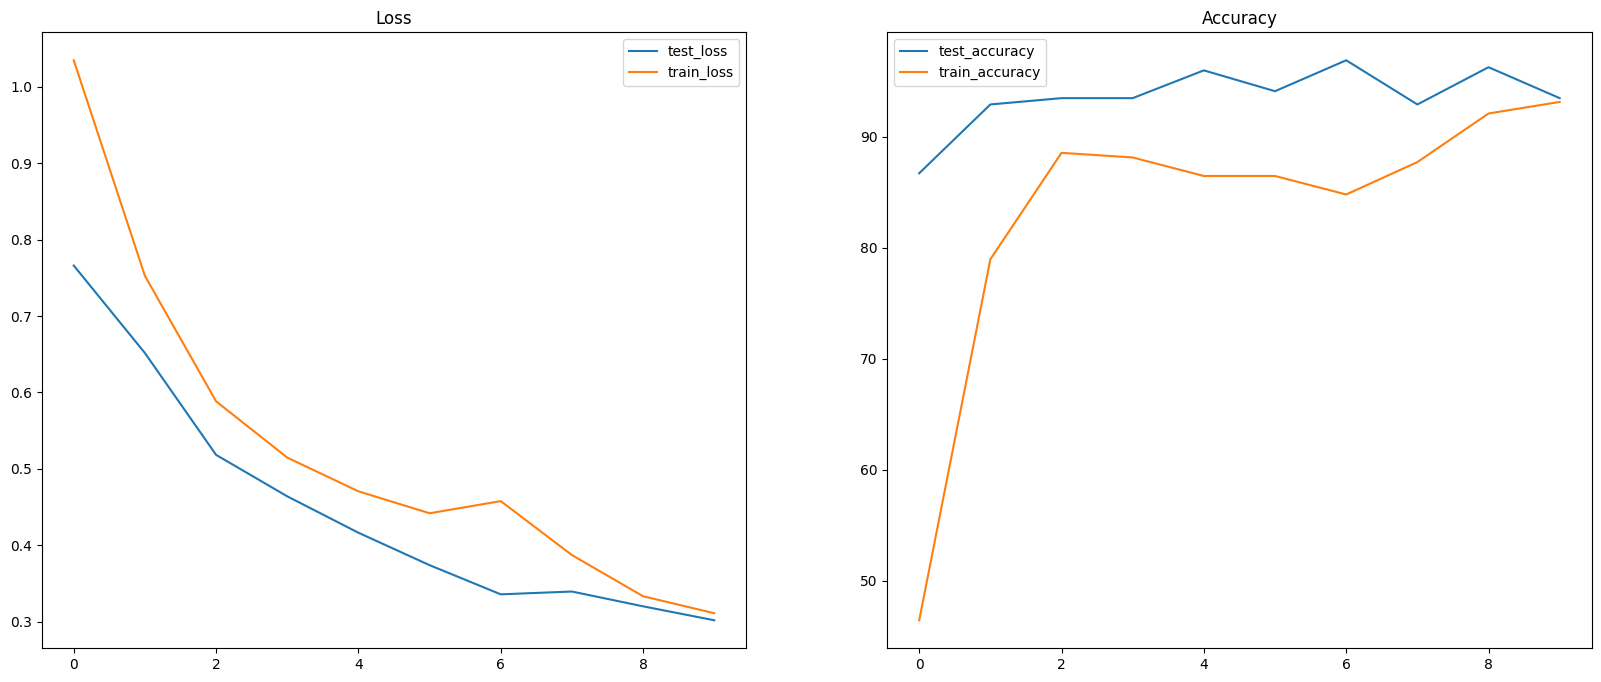

In [36]:
plt.figure(figsize = (20,8))
plt.subplot(1 , 2 , 1)
plt.plot(efficient_resuls["test_loss"])
plt.plot(efficient_resuls["train_loss"])
plt.legend(["test_loss" , "train_loss"])
plt.title("Loss")
plt.subplot(1 , 2 , 2)
plt.plot(efficient_resuls["test_accuracy"])
plt.plot(efficient_resuls["train_accuracy"])
plt.legend(["test_accuracy" , "train_accuracy"])
plt.title("Accuracy")
plt.show()

In [58]:
efficient_test_accuracy = round(efficient_resuls["test_accuracy"][-1] , 4)
efficient_test_loss = round(efficient_resuls["test_loss"][-1] , 4)
efficient_train_accuracy = round(efficient_resuls["train_accuracy"][-1] , 4)
efficient_train_loss = round(efficient_resuls["train_loss"][-1] , 4)


efficient_result = {"test_accuracy":efficient_test_accuracy,
                    "test_loss":efficient_test_loss,
                    "train_accuracy":efficient_train_accuracy,
                    "train_loss":efficient_train_loss}

In [62]:
efficient_result

{'test_accuracy': 93.4659,
 'test_loss': 0.3016,
 'train_accuracy': 93.125,
 'train_loss': 0.3108}

#build best vit model again that we have trained
we are going to train the models with our data and finally check their metrics for each of them

for testing we going to:

* first
  * build vit b16 model
  * train it with its data
  * check time, accuarcy, loss
  * plot them

In [113]:
vit_model = vit_b_16(weights = viT_b16_weight)

In [114]:
summary(vit_model,
        input_size = (32 , 3 , 224 , 224),
        col_names = ["input_size" , "output_size" , "num_params" , "trainable"],
        col_width = 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d: 1-1                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder: 1-2                                [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout: 2-1                           [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential: 2-2                        [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]       [32, 197, 768]    

In [115]:
for params in vit_model.parameters():
  params.requires_grad = False

vit_heads = torch.nn.Sequential(
    torch.nn.Linear(in_features = 768 , out_features = len(CLASS_NAMES))
)

vit_model.heads = vit_heads

In [120]:
vit_loss_function = torch.nn.CrossEntropyLoss()
vit_optimizer = torch.optim.Adam(params = vit_model.parameters() , lr=0.001)

vit_results = train(model = vit_model.to(device),
                         epochs = 10,
                         train_data = vit_train_dataLoader,
                         test_data = vit_test_dataLoader,
                         loss_fn = vit_loss_function,
                         optimizer = vit_optimizer,
                         device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.5541 | Train Accuracy: 83.96 | Test Loss: 0.2128 | Test Accuracy: 96.88 
Epoch 1 | Train Loss: 0.1946 | Train Accuracy: 94.58 | Test Loss: 0.1166 | Test Accuracy: 98.12 
Epoch 2 | Train Loss: 0.1374 | Train Accuracy: 96.04 | Test Loss: 0.0943 | Test Accuracy: 97.22 
Epoch 3 | Train Loss: 0.1137 | Train Accuracy: 96.88 | Test Loss: 0.0823 | Test Accuracy: 97.84 
Epoch 4 | Train Loss: 0.1176 | Train Accuracy: 97.29 | Test Loss: 0.0732 | Test Accuracy: 97.22 
Epoch 5 | Train Loss: 0.0822 | Train Accuracy: 98.13 | Test Loss: 0.0750 | Test Accuracy: 97.84 
Epoch 6 | Train Loss: 0.0711 | Train Accuracy: 98.54 | Test Loss: 0.0675 | Test Accuracy: 97.84 
Epoch 7 | Train Loss: 0.0901 | Train Accuracy: 95.63 | Test Loss: 0.0640 | Test Accuracy: 97.84 
Epoch 8 | Train Loss: 0.0566 | Train Accuracy: 98.75 | Test Loss: 0.0638 | Test Accuracy: 97.22 
Epoch 9 | Train Loss: 0.0491 | Train Accuracy: 98.96 | Test Loss: 0.0622 | Test Accuracy: 97.22 

Process Time: 87.51 seconds


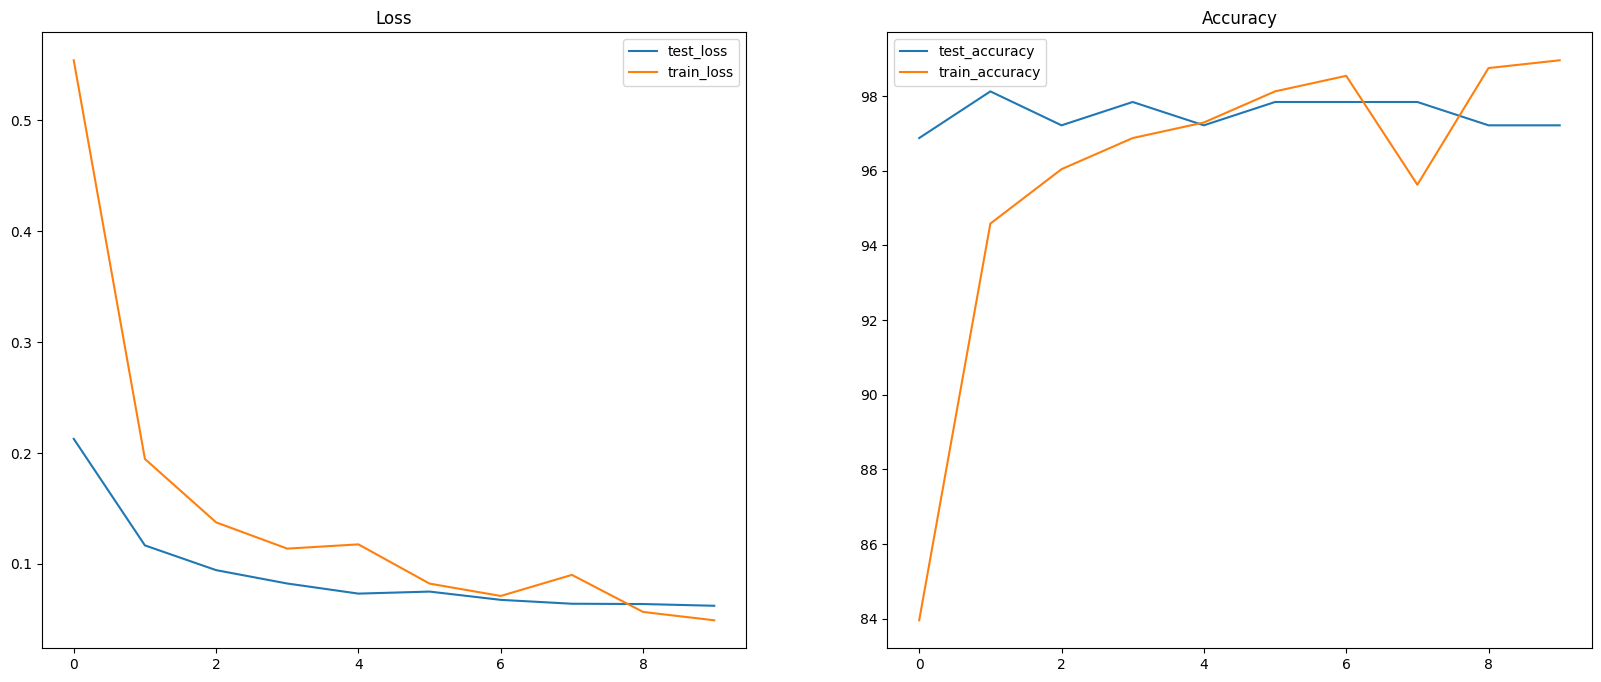

In [121]:
plt.figure(figsize = (20,8))
plt.subplot(1 , 2 , 1)
plt.plot(vit_results["test_loss"])
plt.plot(vit_results["train_loss"])
plt.legend(["test_loss" , "train_loss"])
plt.title("Loss")
plt.subplot(1 , 2 , 2)
plt.plot(vit_results["test_accuracy"])
plt.plot(vit_results["train_accuracy"])
plt.legend(["test_accuracy" , "train_accuracy"])
plt.title("Accuracy")
plt.show()

In [122]:
vit_test_accuracy = round(vit_results["test_accuracy"][-1] , 4)
vit_test_loss = round(vit_results["test_loss"][-1] , 4)
vit_train_accuracy = round(vit_results["train_accuracy"][-1] , 4)
vit_train_loss = round(vit_results["train_loss"][-1] , 4)


vit_result = {"test_accuracy":vit_test_accuracy,
                    "test_loss":vit_test_loss,
                    "train_accuracy":vit_train_accuracy,
                    "train_loss":vit_train_loss}

In [126]:
vit_result

{'test_accuracy': 97.2159,
 'test_loss': 0.0622,
 'train_accuracy': 98.9583,
 'train_loss': 0.0491}

#Compare our results in Accuracy and Loss metrics

In [137]:
vit_and_efficient_comparision = pd.DataFrame({"ViT Model":vit_result , "Efficient Model": efficient_result})

In [138]:
vit_and_efficient_comparision

,ViT Model,Efficient Model
test_accuracy,97.2159,93.4659
test_loss,0.0622,0.3016
train_accuracy,98.9583,93.1250
train_loss,0.0491,0.3108


# Git commands for commiting

In [67]:
# !git status
# !git add --all
# !git commit -a -m "food vision live started"
# !git push origin